#Installing Libraries

In [ ]:
%pip install pandas numpy matplotlib pmdarima prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from google.colab import files
files.upload()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.1 MB/s eta 0:00:00


Saving steam.csv to steam.csv


{'steam.csv': b'appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price\r\n10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19\r\n20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99\r\n30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99\r\n40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-Player;Valve Anti-Cheat enabled,Action,Action;FPS;

#Initial Cleaning

In [ ]:
df = pd.read_csv('/content/steam.csv')

# Retain only 'release_date' and 'numids' columns
df = df[['release_date', 'appid']]

# Convert 'release_date' to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Drop rows with invalid dates
df = df.dropna(subset=['release_date'])

# Filter data to include only records before 2019 (incomplete info)
df = df[df['release_date'] < '2019-01-01']

#Making a new column just for the release year; we can use this in a time series model
df['release_year'] = df['release_date'].dt.year

# Number of unique game releases per month
df_monthly = df.resample('M', on='release_date').size().reset_index(name='game_releases')

<ipython-input-2-ef4dd34eab81>:19: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='release_date').size().reset_index(name='game_releases')


##Actual Release Values

In [ ]:
actual_values_years = [8094, 9682, 11298, 12372, 14296, 18958]
actual_values_months = [
    ["2019-01-01", 621], ["2019-02-01", 642], ["2019-03-01", 626], ["2019-04-01", 690],
    ["2019-05-01", 754], ["2019-06-01", 596], ["2019-07-01", 619], ["2019-08-01", 763],
    ["2019-09-01", 694], ["2019-10-01", 741], ["2019-11-01", 684], ["2019-12-01", 664],
    ["2020-01-01", 683], ["2020-02-01", 712], ["2020-03-01", 674], ["2020-04-01", 774],
    ["2020-05-01", 805], ["2020-06-01", 723], ["2020-07-01", 862], ["2020-08-01", 856],
    ["2020-09-01", 817], ["2020-10-01", 989], ["2020-11-01", 878], ["2020-12-01", 911],
    ["2021-01-01", 825], ["2021-02-01", 954], ["2021-03-01", 1013], ["2021-04-01", 889],
    ["2021-05-01", 856], ["2021-06-01", 872], ["2021-07-01", 910], ["2021-08-01", 907],
    ["2021-09-01", 980], ["2021-10-01", 1136], ["2021-11-01", 972], ["2021-12-01", 986],
    ["2022-01-01", 905], ["2022-02-01", 914], ["2022-03-01", 1124], ["2022-04-01", 861],
    ["2022-05-01", 1076], ["2022-06-01", 909], ["2022-07-01", 1020], ["2022-08-01", 1051],
    ["2022-09-01", 1095], ["2022-10-01", 1204], ["2022-11-01", 1160], ["2022-12-01", 1054],
    ["2023-01-01", 1005], ["2023-02-01", 1104], ["2023-03-01", 1248], ["2023-04-01", 1143],
    ["2023-05-01", 1155], ["2023-06-01", 1087], ["2023-07-01", 1139], ["2023-08-01", 1235],
    ["2023-09-01", 1211], ["2023-10-01", 1382], ["2023-11-01", 1335], ["2023-12-01", 1252],
    ["2024-01-01", 1214], ["2024-02-01", 1515], ["2024-03-01", 1451], ["2024-04-01", 1425],
    ["2024-05-01", 1580], ["2024-06-01", 1433], ["2024-07-01", 1534], ["2024-08-01", 1649],
    ["2024-09-01", 1538], ["2024-10-01", 1965], ["2024-11-01", 1935], ["2024-12-01", 1719],
]

##Game Releases Over Time (Years)


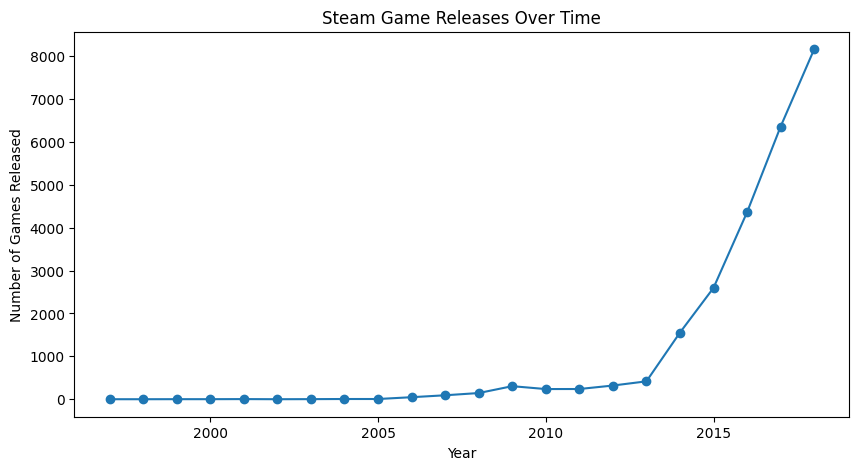

In [ ]:
games_per_year = df.groupby('release_year')['appid'].count()
plt.figure(figsize=(10,5))
plt.plot(games_per_year.index, games_per_year.values, marker='o', linestyle='-')
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.title("Steam Game Releases Over Time")
plt.show()

#ETS

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model = ExponentialSmoothing(games_per_year, trend="add", seasonal=None)
model_fit = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
forecast_steps = 6
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for forecasted values
forecast_years = range(2019, 2025)
forecast_df = pd.DataFrame({'Year': forecast_years, 'Forecasted Games': forecast})
forecast_values2 = []
for index, row in forecast_df.iterrows():
    forecast_values2.append(row['Forecasted Games'])

# Display forecasted values
print(forecast_df)


    Year  Forecasted Games
22  2019       9995.709435
23  2020      11824.366699
24  2021      13653.023962
25  2022      15481.681225
26  2023      17310.338489
27  2024      19138.995752


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


##Predicted ETS vs Actual

<ipython-input-10-5e8b33c87861>:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  actual_years = pd.date_range(start='2019', periods=len(actual_values_years), freq='Y')  # Yearly intervals


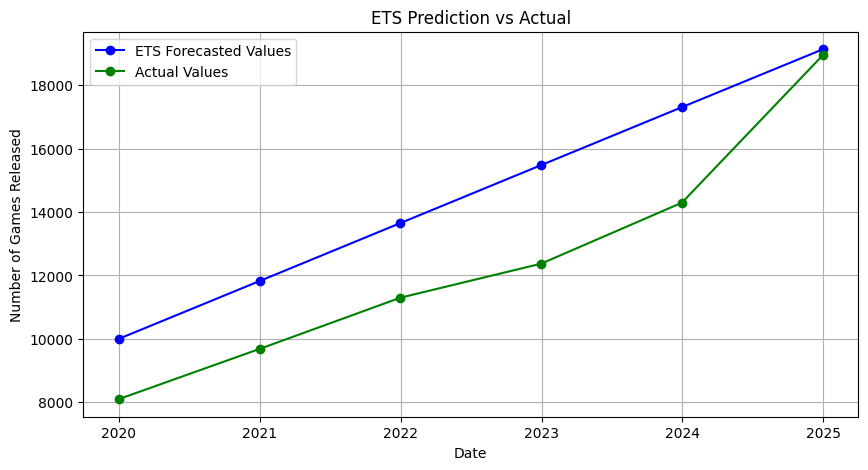

In [ ]:
actual_years = pd.date_range(start='2019', periods=len(actual_values_years), freq='Y')  # Yearly intervals
comparison_df = pd.DataFrame({
    'Forecasted ETS': forecast_values2,
    #'Forecasted ARIMA': forecast_values,
    'Actual': actual_values_years,
}, index=actual_years)
plt.figure(figsize=(10, 5))

# Plot ETS values
plt.plot(comparison_df.index, comparison_df['Forecasted ETS'], label='ETS Forecasted Values', marker='o', color='blue')

#Plot actual values
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual Values', marker='o', color='green')

plt.title("ETS Prediction vs Actual")
plt.xlabel("Date")
plt.ylabel("Number of Games Released")
plt.legend()
plt.grid()
plt.show()

#Switching to Monthly

In [ ]:
# Sort by monthly
df['release_month'] = df['release_date'].dt.to_period('M')
games_per_month = df.groupby('release_month')['appid'].count()

# Convert to a time-series object
games_per_month = games_per_month.to_timestamp()

##Game Releases Over Time (Months)

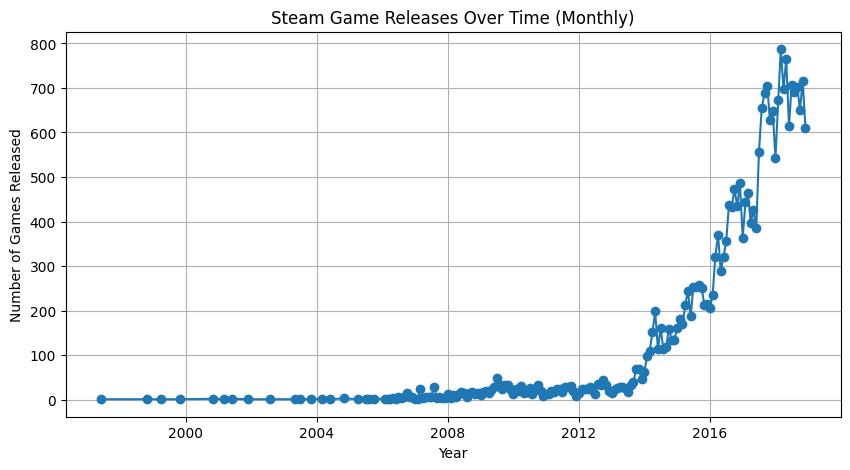

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(games_per_month, marker='o')
plt.title("Steam Game Releases Over Time (Monthly)")
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.grid()
plt.show()

#SARIMA (Seasonal ARIMA)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [ ]:
auto_arima_model = pm.auto_arima(
    df_monthly["game_releases"], seasonal=True, m=12, stepwise=True, trace=False, max_d=1
)

# Fit final ARIMA model
model = ARIMA(df_monthly["game_releases"], order=auto_arima_model.order)
model_fit = model.fit()

# Predict from 2019 to 2024 (72 months)
future_months = pd.date_range(start="2019-01-01", periods=72, freq="MS")
forecast = model_fit.forecast(steps=72)

# Create dataframe for comparison
actual_df = pd.DataFrame(actual_values_months, columns=["date", "actual_releases"])
actual_df["date"] = pd.to_datetime(actual_df["date"])

# Combine actual and predicted data
forecast_df = pd.DataFrame({"date": future_months, "predicted_releases": forecast})
comparison_df = actual_df.merge(forecast_df, on="date", how="left")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10

##Predicted SARIMA vs Actual

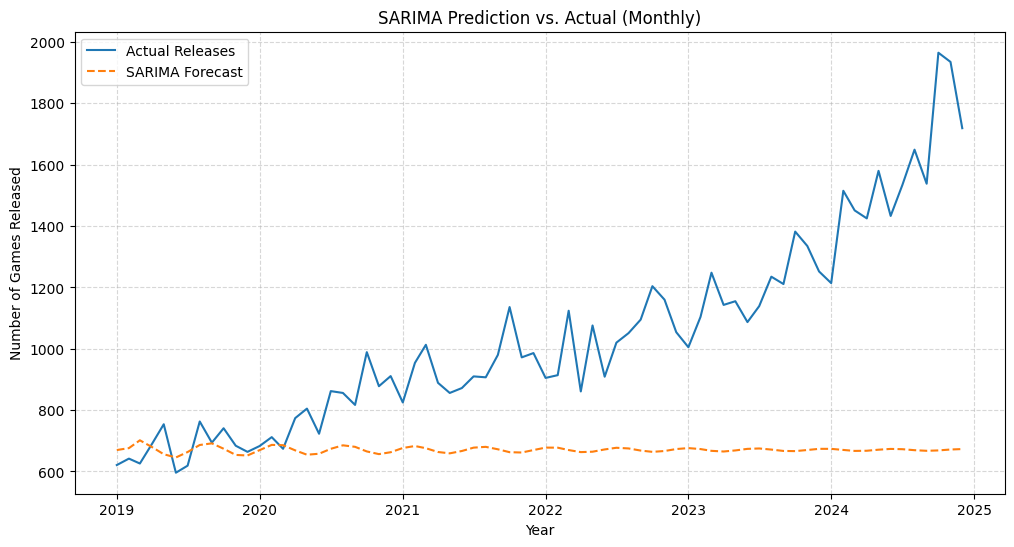

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual values (solid line)
plt.plot(comparison_df["date"], comparison_df["actual_releases"],
         label="Actual Releases", linestyle="solid", color="#1f77b4")

# Plot SARIMA forecasted values (dashed line)
plt.plot(comparison_df["date"], comparison_df["predicted_releases"],
         label="SARIMA Forecast", linestyle="dashed", color="#ff7f0e")



plt.title("SARIMA Prediction vs. Actual (Monthly)")
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

#ETS (Monthly)

In [ ]:
df_monthly.set_index("release_date", inplace=True)

# Fit ETS model with additive trend and seasonality
model = ExponentialSmoothing(
    df_monthly["game_releases"],
    trend="add",        # Additive trend
    seasonal="add",     # Additive seasonality
    seasonal_periods=12 # Monthly seasonality
).fit()


forecast = model.forecast(steps=72)


forecast_index = pd.date_range(start=df_monthly.index[-1] + pd.offsets.MonthEnd(1), periods=72, freq="MS")
forecast_df = pd.DataFrame({"date": forecast_index, "predicted_releases": forecast})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


##Predicted ETS vs Actual

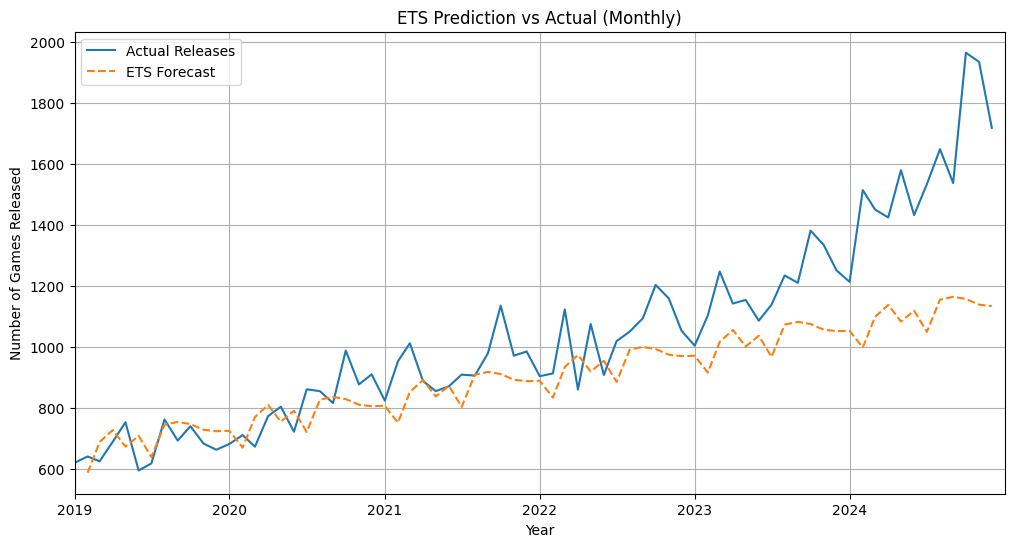

In [ ]:
actual_df = pd.DataFrame(actual_values_months, columns=["date", "actual_releases"])
actual_df["date"] = pd.to_datetime(actual_df["date"])

# Combine actual and predicted data
comparison_df = actual_df.merge(forecast_df, left_on="date", right_on="date", how="left")

plt.figure(figsize=(12, 6))

# Plot observed data
# Plot actual releases
plt.plot(comparison_df["date"], comparison_df["actual_releases"], label="Actual Releases", linestyle="solid")

# Plot ETS forecast
plt.plot(comparison_df["date"], comparison_df["predicted_releases"], label="ETS Forecast", linestyle="--")

# Zoom in on 2019–2024
plt.xlim(pd.Timestamp("2019-01-01"), pd.Timestamp("2024-12-31"))

# Add labels, title, and legend
plt.xlabel("Year")
plt.ylabel("Number of Games Released")
plt.title("ETS Prediction vs Actual (Monthly)")
plt.legend()
plt.grid()
plt.show()

#Prophet

In [ ]:
from prophet import Prophet

# Aggregate the number of games released per month
df_monthly = df.resample('M', on='release_date').size().reset_index(name='game_count')

# Rename columns for Prophet
df_prophet = df_monthly.rename(columns={'release_date': 'ds', 'game_count': 'y'})

# Initialize and fit the Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(df_prophet)

# Create a future dataframe for forecasting
future = model.make_future_dataframe(periods=72, freq='M')  # Forecast for 5 years

# Make predictions
forecast = model.predict(future)

<ipython-input-29-587237f75551>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M', on='release_date').size().reset_index(name='game_count')
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5lvh31u/x07fd_79.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpu5lvh31u/itbd66bz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32292', 'data', 'file=/tmp/tmpu5lvh31u/x07fd_79.json', 'init=/tmp/tmpu5lvh31u/itbd66bz.json', 'output', 'file=/tmp/tmpu5lvh31u/prophet_modelhzmcg73d/prophet_model-20250131033926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
03:39:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:39:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/pyth

##Predicted Prophet vs Actual

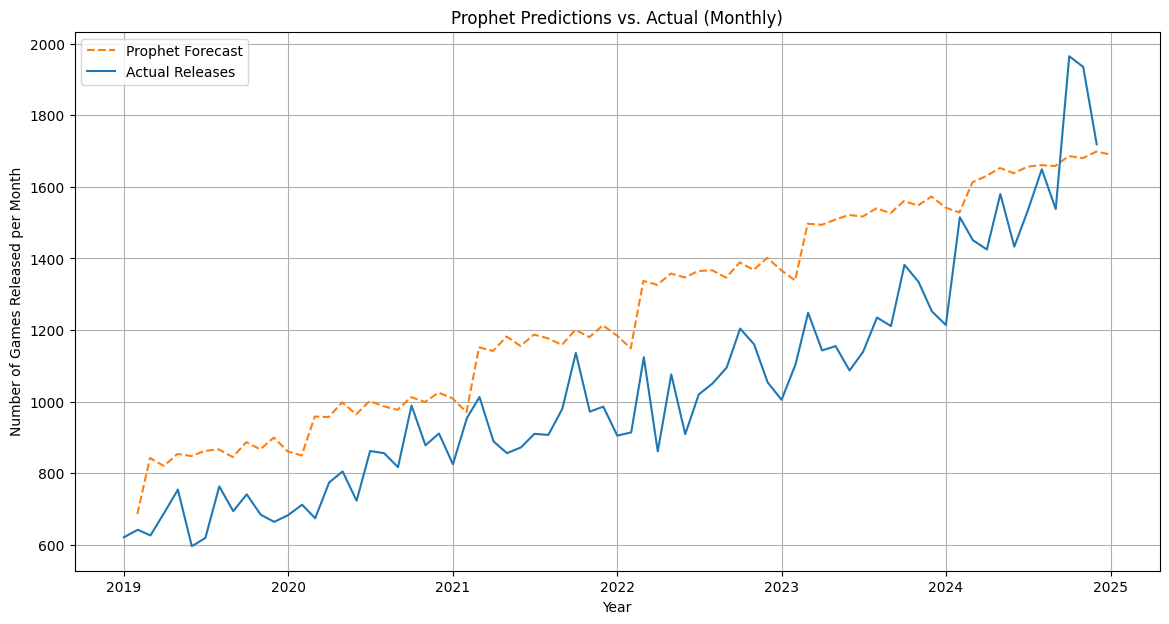

In [ ]:
# Filter forecast data to only show predictions for 2019-2024
forecast_zoomed = forecast[(forecast["ds"] >= "2019-01-01") & (forecast["ds"] <= "2024-12-31")]

# Filter actual data for the same period
df_actual = pd.DataFrame(actual_values_months, columns=["ds", "y"])
df_actual["ds"] = pd.to_datetime(df_actual["ds"])
df_actual_zoomed = df_actual[(df_actual["ds"] >= "2019-01-01") & (df_actual["ds"] <= "2024-12-31")]

# Plot only the prediction period
plt.figure(figsize=(14, 7))
plt.plot(forecast_zoomed["ds"], forecast_zoomed["yhat"], label="Prophet Forecast", linestyle="--", color="#ff7f0e")
plt.plot(df_actual_zoomed["ds"], df_actual_zoomed["y"], label="Actual Releases", color="#1f77b4")
plt.title("Prophet Predictions vs. Actual (Monthly)")
plt.xlabel("Year")
plt.ylabel("Number of Games Released per Month")
plt.legend()
plt.grid(True)
plt.show()